Imports

In [28]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper

Data Transformation

In [29]:
transform = transforms.Compose([transforms.ToTensor()
                              ])

Training and Test data from MNIST data set

In [30]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
#print(trainset[1])
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

Initializing the model

In [31]:
model = feed_forward.HypFF()

In [32]:
print(model)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=64, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=64, out_features=32, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=32, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [33]:
learning_rate = 1e-4
momentum = 0.9

Loss Function

In [34]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

out = model(images) #output
loss = criterion(out, labels) #calculate the loss

Optimizer

In [35]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [36]:

time0 = time()

epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.1728380678812664
Epoch 1 - Training loss: 1.9656077925364177
Epoch 2 - Training loss: 1.868717059326172
Epoch 3 - Training loss: 1.8169710972468058
Epoch 4 - Training loss: 1.7853688037872315
Epoch 5 - Training loss: 1.764041160329183
Epoch 6 - Training loss: 1.7484642840067546
Epoch 7 - Training loss: 1.7364372671763102
Epoch 8 - Training loss: 1.7267818621953328
Epoch 9 - Training loss: 1.718831936709086
Epoch 10 - Training loss: 1.7121133106867472
Epoch 11 - Training loss: 1.706356097984314
Epoch 12 - Training loss: 1.701347338994344
Epoch 13 - Training loss: 1.6969711228052775
Epoch 14 - Training loss: 1.693095805422465

Training Time (in minutes) = 5.318171489238739


Predicted Digit = 4


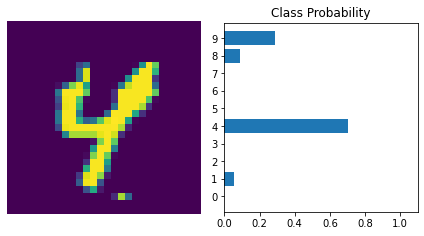

In [37]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    out = model(img)

ps = out
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [38]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.8648
